# Creating dataset

# Creating classification model
##### Following this tutorial
       www.youtube.com/watch?v=WvoLTXIjBYU
##### Characteristics
 - Sequencial Model
 - Fully trained on this dataset

In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D
import keras
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
print(keras.__version__)

2.4.3


In [26]:
DATASET_PATH = '../../datasets/Classification/Dataset - 7 dias'
CATEGORIES = ["Normal", "Anormal", "Morta"]

In [27]:
images_raw = open(os.path.join(DATASET_PATH, "7_days_images.pickle" ), "rb")
images = pickle.load(images_raw)

labels_raw = open(os.path.join(DATASET_PATH, "7_days_labels.pickle" ), "rb")
labels = pickle.load(labels_raw)

#reshape images
IMG_SIZE = 256

print(len(images))

1184


###### Train Test split

In [28]:
images = np.array(images)

from sklearn.model_selection import train_test_split

train_images, test_images, train_labels, test_labels = train_test_split(images, labels, test_size=0.2, stratify=labels)

In [5]:
print("In training:")
for i in range(0,3):
    print(f'Class {i}: {round(100 * np.count_nonzero(np.array(train_labels) == i) / len(train_labels), 2)}%')
print("In test:")
for i in range(0,3):
    print(f'Class {i}: {round(100 * np.count_nonzero(np.array(test_labels) == i) / len(test_labels), 2)}%')
    
# print("Proporção entre classes:")

In training:
Class 0: 78.99%
Class 1: 17.0%
Class 2: 4.01%
In test:
Class 0: 78.9%
Class 1: 16.88%
Class 2: 4.22%


#### Ajustando o dataset desbalanceado

###### Data augmentation -> data generator

In [6]:
# data augmentation with ImageDataGenerator -> did not go well
# from keras.preprocessing.image import ImageDataGenerator
# datagen = ImageDataGenerator(
#     featurewise_center=True,
#     featurewise_std_normalization=False,
#     rotation_range=20,
#     width_shift_range=0.2,
#     height_shift_range=0.2,
#     horizontal_flip=True,
#     validation_split=0.25
# )
# datagen.fit(train_images)

# # it = datagen.flow(train_images, batch_size=1, save_to_dir="test", shuffle= True)

# # # generate samples and plot
# # for i in range(50):
# #      # generate batch of images
# #     batch = it.next()
# #     # convert to unsigned integers for viewing
# #     image = batch[0].astype('uint8')
# #     # plot raw pixel data
# #     plt.imshow(image, cmap="gray")
# #     plt.show()
# # show the figure

###### Weighted Classes 

In [7]:
## Trying class weights
#it does not work withone hot encoded data
# from sklearn.utils import class_weight
# class_weights = class_weight.compute_class_weight('balanced',
#                                                  np.unique(train_labels),
#                                                  train_labels)

# from sklearn.utils import compute_sample_weight
# sample_weights = compute_sample_weight('balanced', train_labels)  #->>>> remember to add the weights in model.fit


###### SMOTE

In [8]:
# classes, counts = np.unique(train_labels, return_counts=True)
# print(f"The number of elements for each class in training now are\nClass 0: {counts[0]}\nClass 1 {counts[1]}\nClass 2 {counts[2]}\n")

In [9]:
# from imblearn.over_sampling import SMOTE
# sm = SMOTE(random_state=42)

# train_images_shape = train_images.shape
# train_images = train_images.reshape((train_images_shape[0], IMG_SIZE * IMG_SIZE * 3))
# train_images, train_labels = sm.fit_resample(train_images, train_labels)


In [10]:
# train_images_shape = train_images.shape
# train_images = train_images.reshape((train_images_shape[0], IMG_SIZE, IMG_SIZE, 3))


In [11]:
# classes, counts = np.unique(train_labels, return_counts=True)
# print(f"The number of elements for each class in training now are\nClass 0: {counts[0]}\nClass 1 {counts[1]}\nClass 2 {counts[2]}\n")

##### One hot label encoding

In [29]:
import pandas as pd
train_labels = pd.get_dummies(train_labels)
train_labels = pd.DataFrame.to_numpy(train_labels)

test_labels_1d = test_labels

test_labels = pd.get_dummies(test_labels)
test_labels = pd.DataFrame.to_numpy(test_labels)

##### Normalizing training images

In [30]:
# train_images = tf.keras.utils.normalize(train_images, axis=0, order=2)

In [31]:
train_images[0].shape

(256, 256, 3)

### Creating the model


In [32]:
EPOCHS = 15
TRAIN_TEST_SPLIT = 0.25
BATCH_SIZE = 32
# print((1 - TRAIN_TEST_SPLIT) * train_images.shape[0],BATCH_SIZE)

In [33]:
base_model = keras.applications.Xception(
    weights='imagenet',  # Load weights pre-trained on ImageNet.
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    include_top=False
)

base_model.trainable = False

inputs = keras.Input(shape=(IMG_SIZE,IMG_SIZE, 3))
# We make sure that the base_model is running in inference mode here,
# by passing `training=False`. This is important for fine-tuning, as you will
# learn in a few paragraphs.
x = base_model(inputs)
# Convert features of shape `base_model.output_shape[1:]` to vectors
x = keras.layers.GlobalAveragePooling2D()(x)
# A Dense classifier 
outputs = keras.layers.Dense(3, activation="sigmoid")(x)

model = keras.Model(inputs, outputs)

my_metrics = ["accuracy",
           tf.keras.metrics.Precision(),
           tf.keras.metrics.Recall(),
           tf.keras.metrics.AUC(),
           tf.keras.metrics.TruePositives(),
           tf.keras.metrics.TrueNegatives(),
           tf.keras.metrics.FalsePositives(),
           tf.keras.metrics.FalseNegatives(),]

opt = keras.optimizers.Adam(learning_rate=0.00001)
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=my_metrics)



In [39]:
from keras.callbacks import ModelCheckpoint
print(keras.__version__)
METRICDIR = './metricas/classificacao/3_d/smote_transfer_learning/'
MODELDIR = os.path.join(METRICDIR, "model")
CHECKPOINT_DIR = os.path.join(MODELDIR, "best_checkpoint")
checkpoint = ModelCheckpoint(CHECKPOINT_DIR, monitor="val_precision_1", verbose=1,
    save_best_only=True, mode='max', save_freq='epoch')

2.4.3


In [40]:
history = model.fit(train_images, train_labels, batch_size = BATCH_SIZE, epochs = EPOCHS, validation_split=TRAIN_TEST_SPLIT, callbacks=[checkpoint])

Epoch 1/15
23/23 [==============================] - 84s 4s/step - loss: 1.7921 - accuracy: 0.3634 - precision_1: 0.3687 - recall_1: 0.7141 - auc_1: 0.5783 - true_positives_1: 507.0000 - true_negatives_1: 552.0000 - false_positives_1: 868.0000 - false_negatives_1: 203.0000 - val_loss: 1.7496 - val_accuracy: 0.3755 - val_precision_1: 0.3912 - val_recall_1: 0.7511 - val_auc_1: 0.6076 - val_true_positives_1: 178.0000 - val_true_negatives_1: 197.0000 - val_false_positives_1: 277.0000 - val_false_negatives_1: 59.0000

Epoch 00001: val_precision_1 improved from -inf to 0.39121, saving model to ./metricas/classificacao/3_d/smote_transfer_learning/model/best_checkpoint
INFO:tensorflow:Assets written to: ./metricas/classificacao/3_d/smote_transfer_learning/model/best_checkpoint/assets
Epoch 2/15
23/23 [==============================] - 103s 5s/step - loss: 1.5970 - accuracy: 0.4056 - precision_1: 0.3902 - recall_1: 0.7437 - auc_1: 0.6165 - true_positives_1: 528.0000 - true_negatives_1: 595.0000 


Epoch 00011: val_precision_1 improved from 0.51442 to 0.52163, saving model to ./metricas/classificacao/3_d/smote_transfer_learning/model/best_checkpoint
INFO:tensorflow:Assets written to: ./metricas/classificacao/3_d/smote_transfer_learning/model/best_checkpoint/assets
Epoch 12/15
23/23 [==============================] - 73s 3s/step - loss: 0.7413 - accuracy: 0.7507 - precision_1: 0.5301 - recall_1: 0.9056 - auc_1: 0.8210 - true_positives_1: 643.0000 - true_negatives_1: 850.0000 - false_positives_1: 570.0000 - false_negatives_1: 67.0000 - val_loss: 0.8175 - val_accuracy: 0.7131 - val_precision_1: 0.5301 - val_recall_1: 0.9283 - val_auc_1: 0.8172 - val_true_positives_1: 220.0000 - val_true_negatives_1: 279.0000 - val_false_positives_1: 195.0000 - val_false_negatives_1: 17.0000

Epoch 00012: val_precision_1 improved from 0.52163 to 0.53012, saving model to ./metricas/classificacao/3_d/smote_transfer_learning/model/best_checkpoint
INFO:tensorflow:Assets written to: ./metricas/classifica

##### Loading the best model for testing

In [41]:
model = keras.models.load_model(CHECKPOINT_DIR)

##### Testing the model

In [49]:
test_labels_1d = []
for label in test_labels:
    if (label == [1, 0, 0]).all():
        test_labels_1d.append(0)
    elif (label == [0, 1, 0]).all():
        test_labels_1d.append(1)
    else:
        test_labels_1d.append(2)

[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1, 0, 0, 0, 0, 0, 0, 1, 0, 2, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 2, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 2, 1, 0, 0, 0, 2, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 2, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[[1 0 0]
 [1 0 0]
 [1 0 0]
 [0 1 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [0 0 1]
 [0 1 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [0 1 0]
 [1 0 0]
 [0 0 1]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [0 1 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [0 1 0]


In [51]:
prediction = model.predict(test_images, batch_size=1)

prediction = tf.argmax(prediction, axis=-1)

In [52]:
from sklearn import metrics
print(metrics.classification_report(test_labels_1d, prediction, digits=3))

              precision    recall  f1-score   support

           0      0.927     0.813     0.866       187
           1      0.500     0.625     0.556        40
           2      0.391     0.900     0.545        10

    accuracy                          0.785       237
   macro avg      0.606     0.779     0.656       237
weighted avg      0.832     0.785     0.800       237



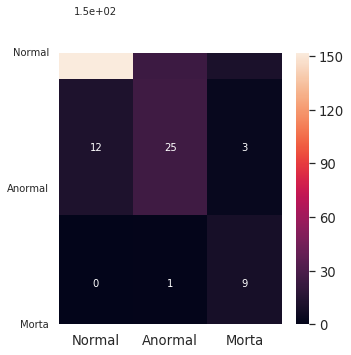

In [78]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

cm = metrics.confusion_matrix(test_labels_1d, prediction)

df_cm = pd.DataFrame(cm, ['Normal', 'Anormal', 'Morta'], ['Normal', 'Anormal', 'Morta'])
plt.figure(figsize=(5,5))
sn.set(font_scale=1.2) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 10}) # font size
plt.yticks(np.arange(3) + 0.8,('Normal','Anormal','Morta'), rotation=0, fontsize="10", va="center")
plt.show()

#### Visualizing model data

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
NUM_METRICS = len(my_metrics) + 1

SAVE = True

def plot_metric(metric_name, chart_name):
    plt.plot(history.history[metric_name], label = metric_name + ' (training data)')
    plt.plot(history.history['val_' + metric_name], label = metric_name + ' (validation data)')
    plt.title(chart_name)
    plt.ylabel( metric_name + ' value')
    plt.xlabel('No. epoch')
    plt.legend(loc="upper left")
    if SAVE and not os.path.exists(METRICDIR):
        os.mkdir(METRICDIR)
    if SAVE:
        plt.savefig(os.path.join(METRICDIR, metric_name))
    plt.show()


In [ ]:
for metric in list(history.history.keys())[:NUM_METRICS]:
    plot_metric(metric, metric + " for soybean classification")
